*Note: This notebook looks best and runs well in the Binder environment provided on the OpenDS4All Github landing page. It also runs well in the Google Collab environment, even in the free tier with no GPUs.*

# Explainable Modeling using UCI's Breast Cancer Data

Explainability, one of the five pillars of AI Trust, is the ability to provide a clear and relevant explanation of a model's decision. This explanation is often difficult to provide due to the complexity of model decisions and the diversity of audiences looking for understanding, but the AIX360 package can help.

This Notebook steps through using the AIX360 package to explain the data and modeling of UCI's Breast Cancer dataset, a tabular dataset that represents a binary classification problem. It demonstrates looking at data with Protodash and explaining model results with BRCG, LIME, and SHAP.

For a more immersive explanation, as well as an introduction to AI trust, please see the related slidedeck in this folder.


### Prepare Environment

In [1]:
#install the aix360 toolikit 
!pip install numpy --upgrade
!pip install aix360
!pip install torchvision==0.9.1

     |████████████████████████████████| 15.7 MB 263 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 58.3 MB 6.8 MB/s 
     |████████████████████████████████| 109.3 MB 61 kB/s 
     |████████████████████████████████| 264 kB 52.7 MB/s 
     |████████████████████████████████| 377 kB 42.8 MB/s 
     |████████████████████████████████| 40 kB 3.9 MB/s 
     |████████████████████████████████| 109.7 MB 1.2 MB/s 
     |████████████████████████████████| 275 kB 42.6 MB/s 
     |████████████████████████████████| 50 kB 6.4 MB/s 
     |████████████████████████████████| 488 kB 42.9 MB/s 
     |████████████████████████████████| 3.1 MB 29.8 MB/s 
     |████████████████████████████████| 7.9 MB 39.8 MB/s 
     |████████████████████████████████| 121 kB 50.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for lime: filename=lime-0.1.1.37-py3-none-any.whl size=284290 sha256=ea6e1f2df7bfe06482cbcf37f5786a67795e1f2368dee3cc1ce0075a0f47be8c
  Stored in directory: /root/.c

In [3]:
#import dependencies 
from __future__ import print_function
import warnings
warnings.filterwarnings('ignore')

import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
import sklearn.datasets
import sklearn.ensemble
from sklearn import svm   
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import time
np.random.seed(1)

from aix360.algorithms.protodash import ProtodashExplainer
from aix360.algorithms.ted.TED_Cartesian import TED_CartesianExplainer
from aix360.algorithms.shap import KernelExplainer
from aix360.datasets.cdc_dataset import CDCDataset
from aix360.datasets.ted_dataset import TEDDataset
from aix360.algorithms.rbm import BRCGExplainer, BooleanRuleCG, FeatureBinarizer
from lime.lime_tabular import LimeTabularExplainer

# the following import is required for access to shap plotting functions and datasets
import shap

Using TensorFlow backend.


### Prepare Data

The Breast Cancer Wisconsin (Diagnostic) Data Set is clean, clear, and part of the sklearn package, which makes it easy to download.

For more information regarding the dataset within sklearn, see: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html

For more information on the dataset itself, how it was compiled, and other references, see: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)

In [4]:
from sklearn.datasets import load_breast_cancer

#load data: note that sklearn objects already have the independant variables and target variables separated
data = load_breast_cancer(as_frame=True)
df = pd.DataFrame(data=data.data, columns=data.feature_names)
numeric_target = pd.Series(data.target)

#keep feature names for explainers
ft_names = data.feature_names

## Step 1: Exploratory Data Analysis

The first step of any ML project is to investigate the data, and the AIX360 toolset includes an algorithm to help with this: Protodash.

We will not be fully diving into Exploratory Data Analysis (EDA) with this notebook, just the use of the AIX360 tool Protodash, so for more information on EDA please see: https://github.com/odpi/OpenDS4All/tree/master/opends4all-resources/opends4all-exploratory-data-analysis


### Using Protodash to Explain a Dataset

Protodash can be used in two ways: as a dataset explainer and as a local explainer. We will look at its use as a dataset explainer.

As a dataset explainer, it selects observations that are representative of the trends and weights of the larger group so that a user can get a "feel" for the entire dataset. For instance, if asked to choose one example, it will choose the most 'average' observation. If asked to choose 10 examples, it will choose 10 that cover the range of the entire dataset. As larger subsets of examples are requested, the statistics of the selected examples will get closer and closer to approximating the statistics of the entire dataset.

To use the .explain function:

* Parameters:  
    * X (int values): dataset to select prototypical explanations from
    * Y (int values): dataset you want to explain
    * m (int): Number of examples
    * kernelType (str - not required): Type of kernel (viz. ‘Gaussian’, / ‘other’)
    * sigma (double - not required): width of kernel
* Output:
    * S: indices of the selected prototypes
    * W: weights of the selected prototypes (how close they are to the Explainable Dataset)


In [5]:
#convert pandas dataframe to numpy
data = df.to_numpy()

#sort the rows by sequence numbers in 1st column 
idx = np.argsort(data[:, 0])  
data = data[idx, :]

#replace nan's (missing values) with 0's
original = data
original[np.isnan(original)] = 0

#delete 1st column (sequence numbers)
PDdata = original[:, 1:]

In [6]:
#instantiate the Protodash explainer
PDexplainer = ProtodashExplainer()

#call it to explain the entire dataset by passing the full dataset as both the X and Y datasets
#change m to change the number of examples to select
(W, S, _) = PDexplainer.explain(PDdata, PDdata, m=3) 

#sort the order of prototypes in set S
idx = np.argsort(S)
S = S[idx]
W = W[idx]

In [7]:
#display the prototypes along with their computed weights
inc_prototypes = df.iloc[S, :].copy()
# Compute normalized importance weights for prototypes
inc_prototypes["Weights of Prototypes"] = np.around(W/np.sum(W), 2) 
inc_prototypes.transpose()

,357,567,568
mean radius,13.870000,20.600000,7.760000
mean texture,16.210000,29.330000,24.540000
mean perimeter,88.520000,140.100000,47.920000
mean area,593.700000,1265.000000,181.000000
mean smoothness,0.087430,0.117800,0.052630
mean compactness,0.054920,0.277000,0.043620
mean concavity,0.015020,0.351400,0.000000
mean concave points,0.020880,0.152000,0.000000
mean symmetry,0.142400,0.239700,0.158700
mean fractal dimension,0.058830,0.070160,0.058840


Breast Cancer mass data may not be immediately understood by the layman, but you can see how a doctor would be able to look at these examples to understand what is contained in the entire dataset.

To prove that the Protodash Explainer approximates the entire dataset, lets compare the stats from the entire dataset to the stats for the dataset that Protodash selected:

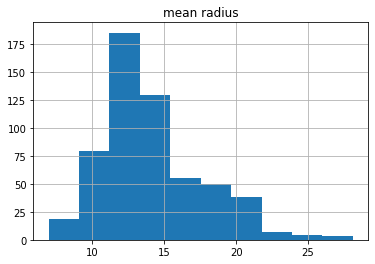

In [8]:
#histogram showing mean radius for whole dataset 
all_fts = df.hist(column='mean radius', bins=10)

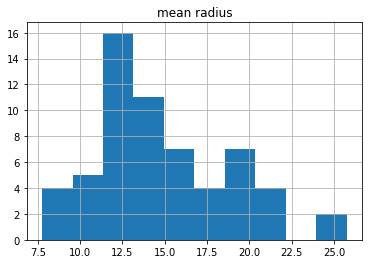

In [9]:
#histograph showing mean radius for larger dataset extracted by ProtoDash
#change 'size' to select number of examples/prototypes
size=60

(W, S, _) = PDexplainer.explain(PDdata, PDdata, m=size) 
idx = np.argsort(S)
S = S[idx]
W = W[idx]
inc_prototypes = df.iloc[S, :].copy()
PD_fts = inc_prototypes.hist(column='mean radius', bins=10)

## Step 2: Global Explanation

The easiest way to produce explainations for model results is to use a simple, explainable algorithm. These kinds of models are referred to as "directly interpretable models."


### Using the Boolean Rules via Column Generation Explainer

The Boolean Rules Column Generation model (BRCG) is the model currently offered in the AIX360 package that is best for classification problems such as this. GLRM can also handle classification, but it is slightly less interpretable since it provides additional functionality to support regression problems. 

BRCG works by creating a series of "yes" or "no" questions that classify the data. In our case, it generates several requirements that classify the observations as benign (1) or malignant (0). Its explainer writes out these "yes" and "no" questions so that a human can easily understand them.

To use, we must first instantiate a BRCG model, then use the BRCG model as input to generate an Explainer model, fitting it to our data and generating predictions with the common functions .fit and .predict. 

The .explain function returns:

* Output:
    * isCNF (bool): flag signaling whether model is CNF (conjunctive) or DNF (disjunctive)
    * rules (list): selected conjunctions formatted as strings

In [10]:
#prepare the data for modeling by scaling it and dividing it into training and test subsets
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(df), columns=ft_names)
X_train, X_test, Y_train, Y_test = train_test_split(X, numeric_target, test_size = 0.3, random_state = 0)

In [11]:
#BRCG requires that all data passed to it is already in a binary form
#transform the data so that all its information is represented in a binary form
fb = FeatureBinarizer(negations=True)
X_train_fb = fb.fit_transform(X_train)
X_test_fb = fb.transform(X_test)

#take a look at the binarized dataset
X_train_fb['mean radius'][:8]

operation        <=                                                    \
value     -1.033895 -0.778566 -0.603329 -0.400827 -0.232122 -0.046377   
478               0         0         1         1         1         1   
303               0         1         1         1         1         1   
155               0         0         0         1         1         1   
186               0         0         0         0         0         0   
101               1         1         1         1         1         1   
97                1         1         1         1         1         1   
20                0         0         0         0         1         1   
153               0         1         1         1         1         1   

operation                                       >                      \
value      0.247578  0.865876  1.534446 -1.033895 -0.778566 -0.603329   
478               1         1         1         1         1         0   
303               1         1         1         1         0         0   
155               1         1         1         1         1         1   
186               0         0         1         1         1         1   
101               1         1         1         0         0         0   
97                1         1         1         0         0         0   
20                1         1         1         1         1         1   
153               1         1         1         1         0         0   

operation                                                              
value     -0.400827 -0.232122 -0.046377  0.247578  0.865876  1.534446  
478               0         0         0         0         0         0  
303               0         0         0         0         0         0  
155               0         0         0         0         0         0  
186               1         1         1         1         1         0  
101               0         0         0         0         0         0  
97                0         0         0         0         0         0  
20                1         0         0         0         0         0  
153               0         0         0         0         0         0

In [12]:
#instantiate and fit the model and explainer (may take a few seconds)
boolean_model = BooleanRuleCG(silent=True)
BRCGexplainer = BRCGExplainer(boolean_model)
BRCGexplainer.fit(X_train_fb, Y_train)

Let's check the performance of the model. If the model does not perform well, its explanation will not be useful.

In [13]:
#get predictions
Y_pred = BRCGexplainer.predict(X_test_fb)

#check the performance of the model
print(f'Accuracy = {accuracy_score(Y_test, Y_pred)}')
print(f'Precision = {precision_score(Y_test, Y_pred)}')
print(f'Recall = {recall_score(Y_test, Y_pred)}')
print(f'F1 = {f1_score(Y_test, Y_pred)}')

Accuracy = 0.9532163742690059
Precision = 0.9545454545454546
Recall = 0.9722222222222222
F1 = 0.963302752293578


That is pretty good! Let's print the "rules" that our model learned.

In [14]:
#get the explanations
e = BRCGexplainer.explain()
isCNF = 'Predict Y=0 if ANY of the following rules are satisfied, otherwise Y=1:'
notCNF = 'Predict Y=1 if ANY of the following rules are satisfied, otherwise Y=0:'

print(isCNF if e['isCNF'] else notCNF)
print()
for rule in e['rules']:
    print(f'  - {rule}')

Predict Y=1 if ANY of the following rules are satisfied, otherwise Y=0:

  - mean concavity > -0.65 AND worst concavity <= -0.44
  - mean texture <= 0.45 AND worst smoothness <= -1.30
  - compactness error > -0.44 AND worst area <= -0.35 AND worst concave points <= 0.97
  - mean concavity <= 1.44 AND worst texture <= -0.95 AND worst perimeter <= 0.81
  - mean concave points <= -0.02 AND area error <= -0.05 AND worst radius <= 0.23 AND worst compactness <= 1.14


## Step 3: Local Explanation

Local Explanations are designed to give insight into specific decisions instead of the entire model. LIME does this by making a "mini model" designed around the one case, and SHAP does this with Shapley values.


### Base Model

First, we create the model that we want to explain, and test it's performance.
   

In [15]:
#instantiate and train a logistic Regression model with training data
log_reg = LogisticRegression()
log_reg.fit(X_train, Y_train)

#check the performance of the model
predictions = log_reg.predict(X_test)
print(f'Accuracy = {accuracy_score(Y_test, predictions)}')
print(f'Precision = {precision_score(Y_test, predictions)}')
print(f'Recall = {recall_score(Y_test, predictions)}')
print(f'F1 = {f1_score(Y_test, predictions)}')

Accuracy = 0.9766081871345029
Precision = 0.9727272727272728
Recall = 0.9907407407407407
F1 = 0.981651376146789


Now that we are confident that our model performs well, we redirect our attention to LIME.


### Using Local Interpretable Model-Agnostic Explanations

Local Interpretable Model-Agnostic Explanation (LIME) generates mutated versions of the observation that we want to explain, feeds them to a previously trained model, and quantifies what mutations alter the result of the model. In this way, LIME can build a directly interpretable mini model that reflects only the decisions that pertain to this specific case, without getting into the complexities of the entire model.

The three LIME explainers included in the AIX360 package (for text, images, and tabular data) are wrappers that use the original LIME algorithms present here: https://github.com/marcotcr/lime

To use the .explain_instance function:

* Parameters:
  * data_row (2d numpy array): row observation to explain
  * classifier_fn: the output from the prediction probability function of the model to explain (For ScikitClassifiers, this is classifier.predict_proba.)
  * labels: labels to be explained.
  * top_labels (optional): if not None, ignore labels and produce explanations for the K
  * num_features (optional): maximum number of features present in explanation
  * num_samples (optional): size of the neighborhood to learn the linear model
  * distance_metric (optional): the distance metric to use for weights.
  * model_regressor (optional): sklearn regressor to use in explanation. 

* Returns:
  * an explanation object

In [16]:
#instantiate explainer
npTrain = X_train.to_numpy()
LIMEexplainer = LimeTabularExplainer(npTrain, mode='classification', class_names = ['malignant', 'benign'], feature_names=ft_names, 
                                categorical_features=None, categorical_names=None, kernel_width=None, kernel=None, 
                                verbose=False, feature_selection='auto', discretize_continuous=True, 
                                discretizer='quartile', sample_around_instance=False, random_state=None, training_data_stats=None)

In [17]:
#choose a specific observation to explain
explainThis = X_test.iloc[12]

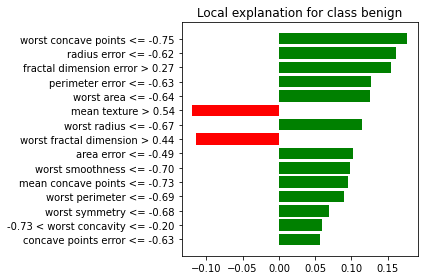

In [18]:
#get its explanation
exp = LIMEexplainer.explain_instance(explainThis, log_reg.predict_proba, num_features=15)

#visualize the explanation
exp.as_pyplot_figure()
plt.tight_layout()

To the left are the characteristics that LIME has found are indicators of the positive class (benign). To the right, the green bars indicate that the observation satisfies the characteristic, while the red bars indicate that the observation does not satisfy that characteristic. 

More green than red indicates the positive class (a benign diagnosis), and more red than green indicates the negative class (a malignant diagnosis). This can be a quick way to illustrate the reasoning of a diagnosis, and also how "sure" the diagnosis is.

Here is another way to illustrate the same LIME explanation:

In [19]:
#another way to visualize the explanation
exp.show_in_notebook()
#print(exp.as_list())

In this case, we can see a similar arrangement of bars, this time orange and blue, and more numbers. To the left are prediction probabilities, that is, how "sure" the model is of the diagnosis. The bar graph itself includes how important that characteristic is to the final diagnosis, and to the right are the actual values of the factors, though in this case they have been scaled and so are not as explainable as they would be with an unscaled dataset. 

This kind of detail is a fantastic resource for those with domain knowledge.

### Using Shapley Additive Explanations

The Shapley Additive Explanations model (SHAP) is based on Shapley values, mathematical quantifiers that were originally developed for game theory. They measure how much a particular factor contributes to the overall result.

SHAP finds a base value that represents the general imbalance in the dataset, and then sequentially adds features and observes how much they alter the final prediction. 
    

In [20]:
shap.initjs()

#initialize and train the explainer
SHAPexplainer = KernelExplainer(log_reg.predict_proba, X_train)

#collect the SHAP values
shap_values = SHAPexplainer.explain_instance(explainThis)

#visualize
shap.force_plot(SHAPexplainer.explainer.expected_value[0], shap_values[0], explainThis, feature_names=ft_names)

Using 398 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In this illustration, we can see that there are factors that pull the diagnosis towards a positive diagnosis (blue) and factors that pull the diagnosis towards a negative diagnosis (red). The segments are labeled with the characteristics of the observation and the sizes of the segments indicate how important that factor is to the final diagnosis.

## Conclusion

Thank you for stepping through this use case. We hope that it has been a useful demonstration of how to use the AIX360 toolkit to explain datasets and models.